In [1]:
# use sympy environment


import numpy as np
%matplotlib inline
from pylab import *
import sympy
import pint

/Users/npk/Dropbox/virtualenv/sympy/lib/python3.6/site-packages/matplotlib/font_manager.py:279: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


## Setup: Units

In [2]:
UR = pint.UnitRegistry()

In [3]:
σ = sigma = UR.stefan_boltzmann_constant

In [4]:

W = UR.watt
J = UR.joule
g = UR.gram
cm = UR.centimeter
kg = UR.kilogram
m = UR.meter
K = UR.kelvin
inch = UR.inch

# Check that room temp is ~ 400 W/m2
P_window = sigma*(290*K)**4
P_window.to(W/m**2)

<Quantity(401.0547085813, 'watt / meter ** 2')>

## Setup: Geometry

In [87]:
A = (10*inch)**2
A = 0.071289*m**2
A_window = np.pi*(10*inch)**2
A_mask = A_window/2


# Solid angle estimated with half-angle relationship below
Ω_hot = 2 * np.pi * (1-np.cos(np.deg2rad(15)))
Ω_cold = 2*np.pi-Ω_hot # Solid angle of cold


print("%4.1f cm^2 of mask sees %1.2f Sr of hot" % (A.to(UR.cm**2).magnitude, Ω_hot))


712.9 cm^2 of mask sees 0.21 Sr of hot


![Heat transfer](data/bgd.png)

In [72]:
L = 1 * m
R_mask = (5 * inch)/L
R_window = (10 * inch)/L
R_i = R_window
R_j = R_mask

S = 1 + (1 + R_j**2)/R_i**2
F_window_to_mask = 1/2 * (S - np.sqrt(S**2 - 4*(R_j/R_i)**2))

In [73]:
F_window_to_mask

<Quantity(0.014938668699873148, 'dimensionless')>

## Setup: Constants

In [74]:
absorption = 0.25 # Worst case absorption of mask material, probably is half this.
T_dewar = 120*K
T_bar_limit = 130*K
N_bars=50

# Aluminum material properties
K_Al = 110 * W/m/K # Thermal conductance
C_J = 600 * J/kg/K
ρ_al = 2.7 * g/cm**3


# Optical properties of materials
ϵ_mask = .15
ϵ_baffles = .85

## Calculate the in/out power from the slitmask

In [75]:
def exchange12(T_1=120*K, T_2=120*K, ϵ_1=1, ϵ_2=1, F_12=1, A_1=1*m**2, A_2=1*m**2):
    num = σ*(T_1**4 - T_2**4)
    den = (1-ϵ_1)/(ϵ_1*A_1) + 1/(A_1*F_12) + (1-ϵ_2)/(ϵ_2*A_2)
    return num/den

In [76]:
P_window_to_mask = A_window * F_window_to_mask * σ * ( (270*K)**4 - (T_dewar + 10*K)**4)
print("Entire masks sees: %s power" % P_window_to_mask.to(W))

Entire masks sees: 0.8633863801603564 watt power


In [77]:
# Exchange from 1->2: Window -> Mask
P_window_to_mask_blackbody = exchange12(T_1=270*K, T_2=T_bar_limit, ϵ_1=1, ϵ_2=1, F_12=F_window_to_mask, A_1=A_window,
                             A_2=A_mask)
print("Entire masks sees: %s power if only BB exchange" % P_window_to_mask_blackbody.to(W))

P_window_to_mask = exchange12(T_1=270*K, T_2=T_bar_limit, ϵ_1=ϵ_baffles, ϵ_2=ϵ_mask, F_12=F_window_to_mask, A_1=A_window,
                             A_2=A_mask)
print("Entire masks sees: %1.3f W power for grey exchange" % P_window_to_mask.to(W).magnitude)

Entire masks sees: 0.8633863801603564 watt power if only BB exchange
Entire masks sees: 0.737 W power for grey exchange


In [78]:
P_incident_bar = P_window_to_mask/N_bars
print("Each bar sees %3.1f mW power" % (P_incident_bar.to(W).magnitude*1000))

Each bar sees 14.7 mW power


Now compute cooling

In [79]:
P_mask_to_all = exchange12(T_1=T_bar_limit, T_2=T_dewar, ϵ_1=.85, ϵ_2=ϵ_baffles, F_12=1, A_1=A_mask,
                             A_2=A_mask*10000)

In [80]:
#P_mask_to_all = A_mask * σ * (T_dewar**4 - (T_bar_limit+6*K)**4) * .85
print("Mask cools by %1.3f W" % (P_mask_to_all.to(W).magnitude))

Mask cools by 0.382 W


In [81]:
d = np.abs(P_mask_to_all/P_window_to_mask)
print("Mask heating / dewar cooling is %1.2f aka ~ 0" % d.magnitude)


Mask heating / dewar cooling is 0.52 aka ~ 0


## Temperature gradients due to this heating, limiting case

If we now dump about 14.2 mW into one tip of the bar, assume there's a sink at the other end of the bar, what is the magnitude of the thermal gradient?

In [82]:
L = 8*inch

# Cross sectional area of bar
A_cross = (1/16)*inch * 1*inch

Delta_T = P_incident_bar * L / K_Al / A_cross
print("Dumping heat in one end, and sinking at the other yield %1.2f K ΔT" % (Delta_T.to(K).magnitude))

Dumping heat in one end, and sinking at the other yield 0.68 K ΔT


## Thermal time constant of bars

In [83]:
time_constant = 3 * (C_J * ρ_al * L * A_cross * Delta_T)/P_window_to_mask

print("Time constant is %2.1f min" % (time_constant.to(UR.minute).magnitude))

Time constant is 0.6 min


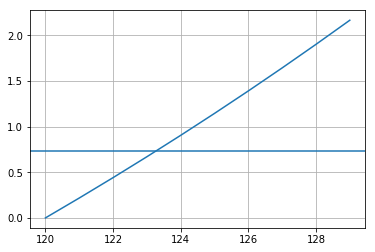

In [85]:
v = np.arange(120,130)
ΔP = A_mask * σ * (.85*T_dewar**4 - (v*K)**4) 
#def exchange12(T_1=120*K, T_2=120*K, ϵ_1=1, ϵ_2=1, F_12=1, A_1=1*m**2, A_2=1*m**2):

ΔP = exchange12(T_2=v*K, ϵ_1=1, ϵ_2=.85, F_12=1, A_1=4*np.pi*(1*m)**2,A_2=A_mask)
plot(v,-ΔP.to(W).magnitude)
axhline(P_window_to_mask.to(W).magnitude)
grid(True)